In [2]:
# 1. run in nvt and look at log to see if stable liquid
# 2. load gsd file, change npt, drop pressure, stop at target pressire, save gsd and look at log and see if it has uniform density save gsd file
# load superheated liquid from gsd and add hot spike 
# equilubrium means averages are stable


# hot spike after eqilibrium
# npt don't expand box manually ramp
# after this code we expand the box based on pressure (npt)


#drop pressure to superheated state
import numpy as np
import hoomd
import fresnel
import matplotlib.pyplot as plt
import scipy
import h5py
import gsd.hoomd
import itertools
import math
import time
import os
import matplotlib

%matplotlib inline
matplotlib.style.use('ggplot')
import matplotlib_inline

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [2]:
# This is not intended as a full tutorial on fresnel - see the
# fresnel user documentation (https://fresnel.readthedocs.io/) if you would like to learn more.

import warnings

import fresnel
import IPython
import packaging.version

device = fresnel.Device()
tracer = fresnel.tracer.Path(device=device, w=300, h=300)

FRESNEL_MIN_VERSION = packaging.version.parse("0.13.0")
FRESNEL_MAX_VERSION = packaging.version.parse("0.14.0")


def render(snapshot):
    if ('version' not in dir(fresnel) or packaging.version.parse(
            fresnel.version.version) < FRESNEL_MIN_VERSION
            or packaging.version.parse(
                fresnel.version.version) >= FRESNEL_MAX_VERSION):
        warnings.warn(
            f"Unsupported fresnel version {fresnel.version.version} - expect errors."
        )
    L = snapshot.configuration.box
    
    scene = fresnel.Scene(device)
    geometry = fresnel.geometry.Sphere(scene,
                                       N=len(snapshot.particles.position),
                                       radius=0.5)
    geometry.material = fresnel.material.Material(color=fresnel.color.linear(
        [252 / 255, 192 / 255, 203 / 255]),
                                                  roughness=0.5)
    geometry.position[:] = snapshot.particles.position[:]
    geometry.outline_width = 0.04
    box = fresnel.geometry.Box(scene, [L[0], L[1], L[2], 0, 0, 0], box_radius=.02)

    scene.lights = [
        fresnel.light.Light(direction=(0, 0, 1),
                            color=(0.8, 0.8, 0.8),
                            theta=math.pi),
        fresnel.light.Light(direction=(1, 1, 1),
                            color=(1.1, 1.1, 1.1),
                            theta=math.pi / 3)
    ]
    scene.camera = fresnel.camera.Orthographic(position=(L[0] * 2, L[1], L[2] * 2),
                                               look_at=(0, 0, 0),
                                               up=(0, 1, 0),
                                               height=L[2] * 1.4 + 1)
    scene.background_alpha = 1
    scene.background_color = (1, 1, 1)
    return IPython.display.Image(tracer.sample(scene, samples=500)._repr_png_())

In [3]:
# box_volumes = []
# pressure_data = []

In [4]:
cpu = hoomd.device.CPU()
simulation = hoomd.Simulation(device=cpu, seed=1)
simulation.create_state_from_gsd(filename='random.gsd')

In [5]:
integrator = hoomd.md.Integrator(dt=1e-3)
cell = hoomd.md.nlist.Cell(buffer=0.2)
lj = hoomd.md.pair.LJ(nlist=cell)
lj.params[('A', 'A')] = dict(epsilon=1, sigma=1)
lj.r_cut[('A', 'A')] = 5.0
integrator.forces.append(lj)

In [6]:
nvt = hoomd.md.methods.ConstantVolume(
    filter=hoomd.filter.All(),
    thermostat=hoomd.md.methods.thermostats.Bussi(kT=1.1))
integrator.methods.append(nvt)
simulation.operations.integrator = integrator

In [7]:
thermodynamic_properties = hoomd.md.compute.ThermodynamicQuantities(
    filter=hoomd.filter.All())
simulation.operations.computes.append(thermodynamic_properties)
simulation.always_compute_pressure = False
simulation.run(1)

In [8]:
logger = hoomd.logging.Logger(categories=['scalar', 'sequence'])
logger.add(thermodynamic_properties)
logger.add(simulation, quantities=['timestep', 'walltime'])

In [9]:
if os.path.exists("log.h5"):
    os.remove("log.h5") # clear file if already created
    
hdf5_writer = hoomd.write.HDF5Log(trigger=hoomd.trigger.Periodic(100), # change how often logger collects here
                                  filename='log.h5',
                                  mode='w',
                                  logger=logger)
simulation.operations.writers.append(hdf5_writer)

In [10]:
equilibration_steps = 500 #was 5000
simulation.run(equilibration_steps)

In [11]:
target_pressure = 0.004

In [12]:
ramp = hoomd.variant.Ramp(A=1, B=1.6009, t_start=simulation.timestep, t_ramp=500)

In [13]:
initial_box = simulation.state.box
final_box = hoomd.Box.from_box(initial_box)  # make a copy of initial_box
final_rho = 0.6009
final_box.volume = simulation.state.N_particles / final_rho

In [14]:
box_resize_trigger = hoomd.trigger.Periodic(10)

In [15]:
box_resize = hoomd.update.BoxResize(
    box1=initial_box, box2=final_box, variant=ramp, trigger=box_resize_trigger
)
simulation.operations.updaters.append(box_resize)

In [16]:
simulation.run(500)

In [17]:
simulation.operations.updaters.remove(box_resize) # stop ramp here

In [18]:
# thermodynamic_properties = hoomd.md.compute.ThermodynamicQuantities(
#     filter=hoomd.filter.All())
# simulation.operations.computes.append(thermodynamic_properties)
# simulation.always_compute_pressure = False
# simulation.run(1)

In [19]:
simulation.always_compute_pressure = True
simulation.run(1)
simulation.always_compute_pressure = False
thermodynamic_properties.pressure

-0.4827552612911769

In [20]:
simulation.run(1000) # changed from 500

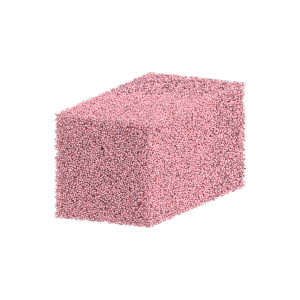

In [21]:
render(simulation.state.get_snapshot())

In [22]:
simulation.always_compute_pressure = True
simulation.run(1)
simulation.always_compute_pressure = False
thermodynamic_properties.pressure

0.0037134535541271784

In [23]:
if os.path.exists("npt_target.gsd"):
    os.remove("npt_target.gsd") # clear file if already created
hoomd.write.GSD.write(state=simulation.state, filename='npt_target.gsd', mode='xb')

In [4]:
simulation.operations.writers.remove(hdf5_writer)
hdf5_file = h5py.File(name='log.h5', mode='r')

In [25]:
volume_data = np.float64(hdf5_file['hoomd-data/md/compute/ThermodynamicQuantities/volume'][:])

In [26]:
print("Volume Data", volume_data)

Volume Data [250000.         250000.         250000.         250000.
 250000.         263290.90174415 279140.11636446 295612.94566325
 312721.42302355 330477.58182838 332289.28347356 332289.28347356
 332289.28347356 332289.28347356 332289.28347356 332289.28347356
 332289.28347356 332289.28347356 332289.28347356 332289.28347356]


In [5]:
pressure_data = np.float64(hdf5_file['hoomd-data/md/compute/ThermodynamicQuantities/pressure'][:])

In [28]:
current_pressure = thermodynamic_properties.pressure
print(current_pressure)

0.0037134535541271784


In [29]:
print("Pressure Data:", pressure_data)

Pressure Data: [ 1.58043382e+00  1.59503409e+00  1.61284700e+00  1.60652276e+00
  1.60942700e+00  3.73822659e-01 -7.90703835e-02 -2.81007228e-01
 -4.07046287e-01 -4.38571654e-01 -8.20832626e-02 -1.95069379e-02
 -5.10243708e-03 -3.02858000e-03 -4.80124386e-03 -2.01381181e-03
 -5.52326108e-03 -5.67338202e-03  3.56643484e-04  3.39896517e-03]


In [6]:
temperature_data = np.float64(hdf5_file['hoomd-data/md/compute/ThermodynamicQuantities/kinetic_temperature'][:])

In [31]:
current_temperature = thermodynamic_properties.kinetic_temperature
print(current_temperature)

1.101577706968703


In [32]:
print("Temperature Data:", temperature_data)

Temperature Data: [1.0979212  1.10183612 1.10286643 1.09940356 1.10260803 1.10043537
 1.09755959 1.09986665 1.09626947 1.09866751 1.10082633 1.09980926
 1.10027169 1.09727452 1.10217652 1.10340021 1.09971783 1.09941536
 1.10232485 1.1017075 ]


In [7]:
print(np.std(temperature_data))

0.0019651244531196056


In [8]:
print(np.std(pressure_data))

0.7389381159408935


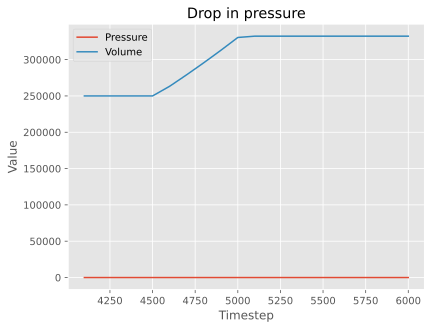

In [33]:
# pressure vs time
timesteps = np.float64(hdf5_file['hoomd-data/Simulation/timestep'][:])

plt.plot(timesteps, pressure_data, label='Pressure')
plt.plot(timesteps, volume_data, label='Volume')
plt.title('Drop in pressure')
plt.xlabel('Timestep')
plt.ylabel('Value')
plt.legend()
plt.show()

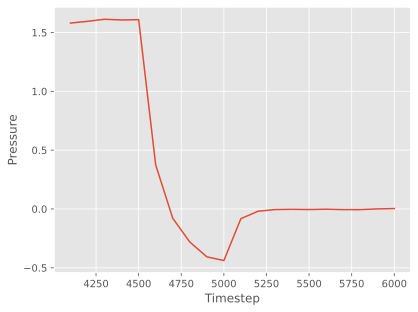

In [34]:
plt.plot(timesteps, pressure_data)
plt.xlabel('Timestep')
plt.ylabel('Pressure')
plt.show()

In [35]:
thermodynamic_properties.volume

332289.2834735602

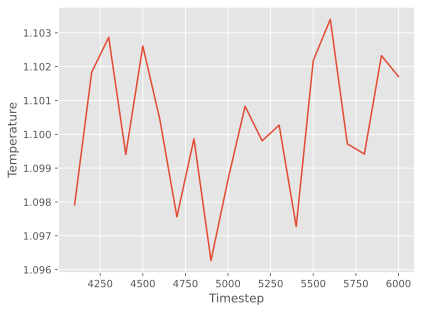

In [36]:
plt.plot(timesteps, temperature_data)
plt.xlabel('Timestep')
plt.ylabel('Temperature')
plt.show()